In [1]:
import sys, os, datetime, json
sys.path.append("../")

from web3 import Web3, HTTPProvider

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set_style("whitegrid")

In [2]:
ALCHEMY_API_KEY = os.environ['ALCHEMY_API_KEY']
web3 = Web3(HTTPProvider(f"https://eth-mainnet.alchemyapi.io/v2/{ALCHEMY_API_KEY}"))

In [17]:
with open("./abi/rai_3crv.json", 'r') as f:
    abi = json.load(f)
rai_3crv = web3.eth.contract(address="0x618788357D0EBd8A37e763ADab3bc575D54c2C7d", abi=abi)
genesis_block_rai_3crv = 13634171

In [21]:
with open("./abi/redemption_price_snapshot.json", 'r') as f:
    abi = json.load(f)
redemption_price_snapshot = web3.eth.contract(address="0x07210B8871073228626AB79c296d9b22238f63cE", abi=abi)
genesis_block_redemption_price_snapshot = 13326946

In [14]:
current_block = web3.eth.block_number
steps = 1000
blocks = range(genesis_block_rai_3crv, current_block, steps)
len(blocks)

143

In [22]:
if not os.path.exists('./data/rai_3crv_pool_data.csv'):

    pool_data = []
    for block_number in blocks:

        block_timestamp = web3.eth.getBlock(block_number)['timestamp']
        block_time = datetime.datetime.fromtimestamp(block_timestamp)

        rai_balance = rai_3crv.functions.balances(0).call(block_identifier=block_number) * 1e-18
        threecrv_balance = rai_3crv.functions.balances(1).call(block_identifier=block_number) * 1e-18
        rai_redemption_price = redemption_price_snapshot.functions.snappedRedemptionPrice().call(block_identifier=block_number) * 1e-27  # 27 decimals!
        rai_balance_usd = rai_balance * rai_redemption_price

        total_pool_balance = rai_balance_usd + threecrv_balance

        pool_data.append(
            {
                "block_number": block_number,
                "block_timestamp": block_timestamp,
                "block_time": block_time,
                "rai_redemption_price": rai_redemption_price,
                "rai_balance": rai_balance,
                "rai_balance_usd": rai_balance_usd,
                "threecrv_balance": threecrv_balance,
                "total_pool_balance": total_pool_balance
            }
        )

        df_rai_3crv = pd.DataFrame(pool_data)
        df_rai_3crv.to_csv('./data/rai_3crv_pool_data.csv')

else:

    df_rai_3crv = pd.read_csv('./data/rai_3crv_pool_data.csv', index_col=[0])

df_rai_3crv

,block_number,block_timestamp,block_time,rai_redemption_price,rai_balance,rai_balance_usd,threecrv_balance,total_pool_balance
0,13634171,1637168359,2021-11-17 17:59:19,3.027653,0.000000,0.00000,0.000000,0.000000
1,13635171,1637181363,2021-11-17 21:36:03,3.027653,0.000000,0.00000,0.000000,0.000000
2,13636171,1637195564,2021-11-18 01:32:44,3.027653,0.000000,0.00000,0.000000,0.000000
3,13637171,1637209110,2021-11-18 05:18:30,3.027653,0.000000,0.00000,0.000000,0.000000
4,13638171,1637223099,2021-11-18 09:11:39,3.027653,0.000000,0.00000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
138,13772171,1639068375,2021-12-09 17:46:15,3.031536,8097.768534,24548.67762,22267.734826,46816.412446
139,13773171,1639082001,2021-12-09 21:33:21,3.031536,8097.768534,24548.67762,22267.734826,46816.412446
140,13774171,1639095980,2021-12-10 01:26:20,3.031536,8097.768534,24548.67762,22267.734826,46816.412446
141,13775171,1639109913,2021-12-10 05:18:33,3.031536,8097.768534,24548.67762,22267.734826,46816.412446


In [23]:
df_rai_3crv.set_index("block_time", inplace=True)

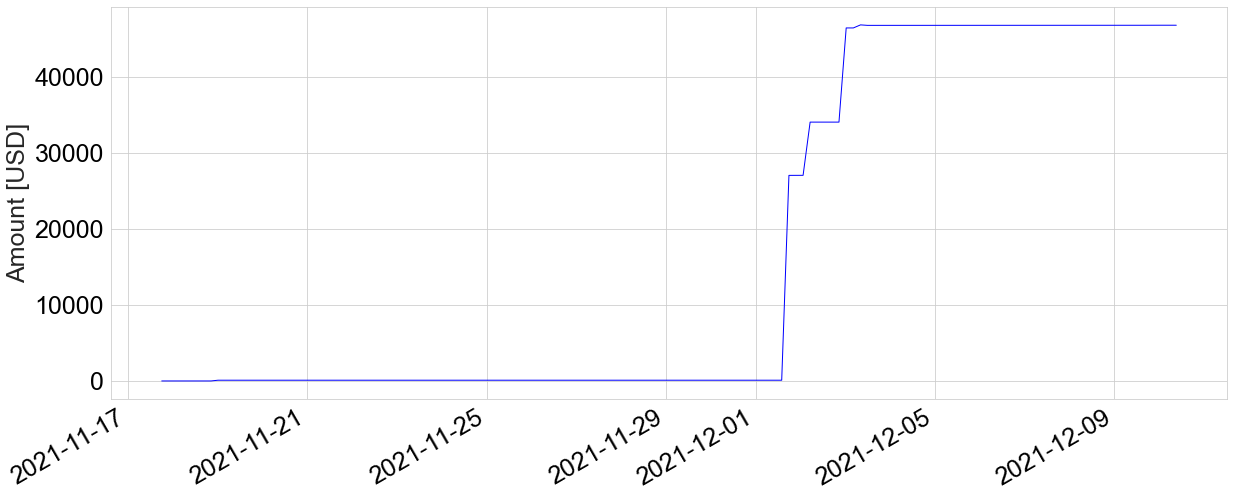

In [24]:
fig, ax = plt.subplots(1,1, figsize=(20, 8))

df_rai_3crv['total_pool_balance'].plot(
    ax=ax,
    color='blue',
    lw=1,
)

ax.set_ylabel("Amount [USD]", fontsize=25)
ax.set_xlabel("")
ax.tick_params(axis='both', which='major', labelsize=25, colors='black')
ax.yaxis.get_major_formatter().set_scientific(False)
ax.yaxis.get_major_formatter().set_useOffset(False);